    # Steven Ly - CNN Exercise - 20-3-2024

# Exploratory Data Analysis

I am using a dataset that contains 25k labeled images of natural landscapes from around the world. It is originated from Kaggle.
This dataset contains 25k labeled images of pixel size 150x150, of which the images are divided into 6 categories. The categories are buildings, forest, glacier, mountain, sea, and street. The dataset is foldered into a training set and a test set. The training set contains 14k images and the test set contains 3k images. The images are in jpg format.


The labeling of the images is as follows:
'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm
import pickle
import tensorflow as tf
import keras

In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
IMAGE_SIZE = (150, 150)
class_names_label

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

I visualised the amount of images per category to validate that each category has a sufficient amount of images to train the model. To validate that the model is not overfitting, I also visualised the amount of images per category in the test set.

It seems that this dataset has a split of 80% training and 20% test. This seems like a balanced split to train the model and validate it.

In [3]:
print("Number of images in each category of the train set:")
for c in class_names:
    print(f"{c}: {len(os.listdir(os.path.join('seg_train/seg_train', c)))}")

Number of images in each category of the train set:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [4]:
print("Number of images in each category of the test set:")
for c in class_names:
    print(f"{c}: {len(os.listdir(os.path.join('seg_test/seg_test', c)))}")

Number of images in each category of the test set:
buildings: 437
forest: 474
glacier: 553
mountain: 525
sea: 510
street: 501


# Data Visualization

I visualised the data to get a better understanding of the images in the dataset. For each category I've displayed 3 images.

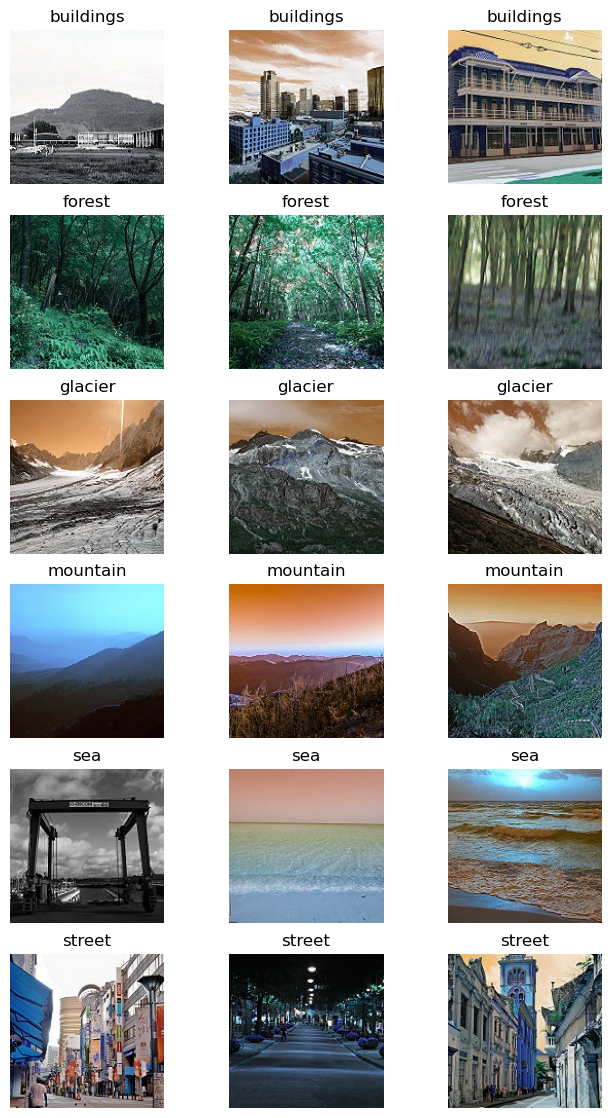

In [5]:
# Define the path to the directory containing the images
base_path = "seg_train/seg_train/"

# Create a figure and axis objects
fig, axes = plt.subplots(6, 3, figsize=(8, 14))

# Loop through each category and display images
for i, cls in enumerate(class_names):
    category_path = os.path.join(base_path, cls)
    image_files = os.listdir(category_path)[:3]
    for j, image_file in enumerate(image_files):
        image_path = os.path.join(category_path, image_file)
        image = cv2.imread(image_path)
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title(cls)

plt.show()

# Data Preprocessing

In this section I will preprocess the data so that my neural network can learn from the images.

The function ```load_data()``` will load the images and labels from the both the training and test set. 

In [6]:
img_size = (80, 80)

In [7]:
def load_data(grayscale=False):
    datasets = ['seg_train/seg_train', 'seg_test/seg_test']
    output = []

    for dataset in datasets:
        images = []
        labels = []

        print("Loading {}".format(dataset))

        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))): # tqdm is used to show the progress of the iteration
                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
                if grayscale:
                    image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, img_size)

                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [8]:
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
print(f"dimensions: {train_images.shape}")

Loading seg_train/seg_train


100%|██████████| 2382/2382 [00:01<00:00, 1285.71it/s]


Loading seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 1229.18it/s]


dimensions: (14034, 80, 80, 3)


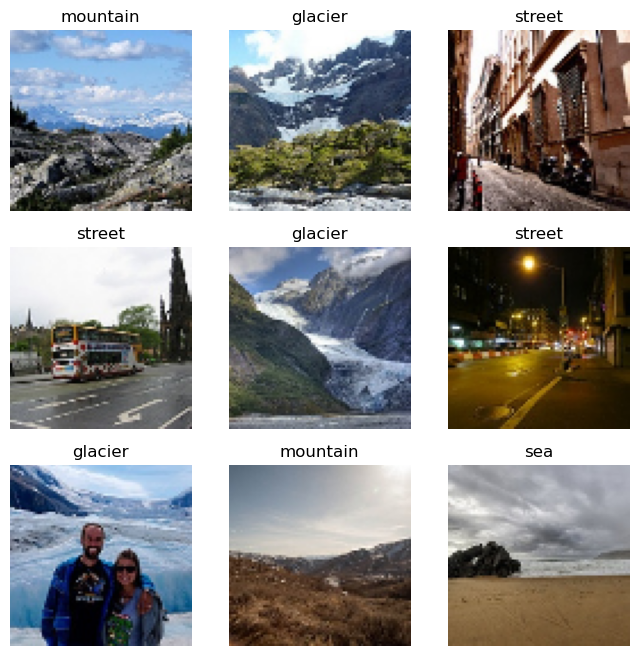

In [9]:
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].astype("uint8"))
    plt.title(class_names[train_labels[i]])
    plt.axis("off")

This is a function which plots out the accuracy and loss of the model. This function will be used to visualize the performance of the model. The fold-index parameter is used to visualize which index the k-fold is at.

In [10]:
def plot_accuracy_loss(history, fold_index=-1):
    fig = plt.figure(figsize=(10,5))
    
    if fold_index >= 0:
        fig.suptitle(f"Fold: {fold_index}", fontsize=16)
    
    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

# Modelling Colored Images

In this section I will train a neural network with the colored images. I will use the ResNet50 model, which is a pre-trained model that is trained on the ImageNet dataset. I want to apply transfer learning from the ResNet50model to the landscape dataset to see if the model can learn effectively.

In the following code I will train the model on the training set and validate it on the test set. I will also use k-fold cross validation to validate the model.

In [11]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

res_net = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
# 
# x = res_net.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(len(class_names), activation='softmax')(x) 
# 
# model = Model(inputs=res_net.input, outputs=predictions)
# 
# for layer in res_net.layers:
#     layer.trainable = False
# 
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 
# history = model.fit(train_images, train_labels, epochs=15, validation_data=(test_images, test_labels))
# plot_accuracy_loss(history)

In [12]:
def save_model(name, model):
    with open(name, 'wb') as f:  # Open in binary write mode 
        pickle.dump(model, f)  # Serialize the model and write to the file
        return "Model saved successfully to cnn_classifier_kfold.pkl"

In [13]:
from tensorflow.keras.layers import Dropout

def run_kfold_model(is_training=False):
    if not is_training:
        f = open('cnn_classifier_kfold.pkl', 'rb')
        trained_model = pickle.load(f)
        f.close()
        return trained_model
    res_net = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
    
    x = res_net.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    
    model_kfold = Model(inputs=res_net.inputs, outputs=predictions)
    
    for layer in res_net.layers:
        layer.trainable = False
    
    kfold = StratifiedKFold(n_splits=3, random_state=25, shuffle=True)

    best_accuracy = 0
    best_weights = None
    
    for i, (train, test) in enumerate(kfold.split(train_images, train_labels)):
        model_kfold.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model_kfold.fit(train_images[train], train_labels[train], epochs=10, validation_data=(test_images, test_labels))
        if max(history.history['val_accuracy']) > best_accuracy:
            best_accuracy = max(history.history['val_accuracy'])
            best_weights = model_kfold.get_weights()
    
        plot_accuracy_loss(history, fold_index=i)
    
    model_kfold.set_weights(best_weights)
    print(f"Best model's validation accuracy: {best_accuracy}")
    print(save_model("cnn_classifier_kfold.pkl", model_kfold))
    return model_kfold

In [14]:
model_kfold = run_kfold_model(is_training=False)

In [15]:
print("Train set evaluation:")
print(model_kfold.evaluate(train_images, train_labels))

print("\n" + "Test set evaluation:")
print(model_kfold.evaluate(test_images, test_labels))

Train set evaluation:
439/439 [==============================] - 67s 150ms/step - loss: 0.0858 - accuracy: 0.9745
[0.0858040377497673, 0.9744905233383179]

Test set evaluation:
94/94 [==============================] - 14s 150ms/step - loss: 0.6377 - accuracy: 0.8597
[0.6377474069595337, 0.859666645526886]


94/94 [==============================] - 14s 146ms/step


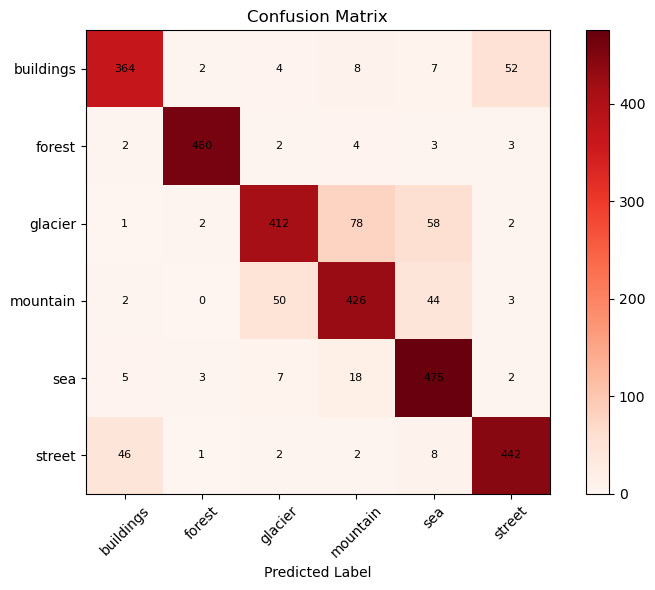

In [16]:
from sklearn.metrics import confusion_matrix

# After the loop
# Get the final confusion matrix
cm = confusion_matrix(test_labels, model_kfold.predict(test_images).argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Predicted Label')

# Add text with counts to each cell
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()

In [17]:
conv_layers = [layer for layer in model_kfold.layers if isinstance(layer, tf.keras.layers.Conv2D)]
last_conv_layer_name = conv_layers[-1].name
last_conv_layer_name

'conv5_block3_3_conv'

In [18]:
def get_grad_cam_heatmap(model, image_array, last_conv_layer_name, pred_index=None):
    """
    Calculates Grad-CAM heatmap for a given image and class.
  
    Args:
        model: TensorFlow CNN model.
        image_array: Preprocessed image as a NumPy array.
        last_conv_layer_name: Name of the last convolutional layer.
        pred_index: Index of the predicted class (optional).
  
    Returns:
        Heatmap as a NumPy array, normalized between 0 and 1.
    """

    # Create a Grad-CAM model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use gradient tape to capture gradients
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(image_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]

    # Calculate gradients for chosen class
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Average gradients and apply ReLU
    pooled_grads = tf.reduce_mean(grads, axis=[0, 1, 2])
    weighted_maps = tf.multiply(last_conv_layer_output, pooled_grads)
    heatmap = tf.reduce_sum(weighted_maps, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-7)

    # Upscale heatmap and normalize
    heatmap = tf.image.resize(heatmap, image_array.shape[1:3])
    return heatmap.numpy()

In [19]:
def preprocess_image(image_path, size):
    # Load the image from disk
    img = keras.utils.load_img(image_path, target_size=size)
    # Convert the image to a NumPy array and scale pixel values to [0, 1]
    img_array = keras.utils.img_to_array(img) / 255.0
    # Add a batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [20]:
def visualize_grad_cam_heatmap(model, image_path, last_conv_layer_name, pred_index=None, size=(80, 80)):
    """
    Preprocesses an image, calculates Grad-CAM heatmap, and visualizes it.
  
    Args:
        model: TensorFlow CNN model.
        image_path: Path to the image file.
        last_conv_layer_name: Name of the last convolutional layer.
        pred_index: Index of the predicted class (optional).
        size: Target size for image preprocessing (optional).
    """
    # Preprocess the image
    image_array = preprocess_image(image_path, size)

    # Get the heatmap
    heatmap = get_grad_cam_heatmap(model, image_array, last_conv_layer_name, pred_index)

    # Load the original image
    original_image = keras.utils.load_img(image_path, target_size=size)
    original_image_array = keras.utils.img_to_array(original_image)

    # Combine original image and heatmap with transparency
    combined_image = original_image_array * 0.5 +heatmap * 0.5

    # Display the combined image  
    plt.figure(figsize=(4, 3))
    plt.imshow(combined_image.astype('uint8'), cmap='viridis')
    plt.axis('off')
    plt.title('Grad-CAM Heatmap')
    plt.show()
    
    # Display the original image
    plt.figure(figsize=(4, 3))
    plt.imshow(original_image, cmap='viridis')
    plt.axis('off')
    plt.title('Original Image')
    plt.show()
    
    # Display the heatmap
    plt.figure(figsize=(4, 3))
    plt.imshow(heatmap, cmap='viridis')
    plt.axis('off')
    plt.title('Heatmap')
    plt.show()

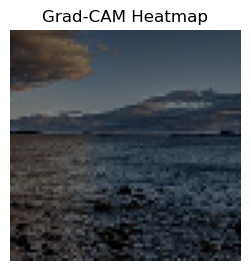

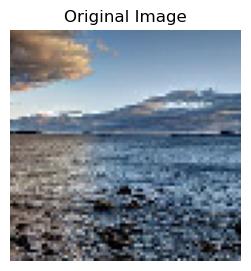

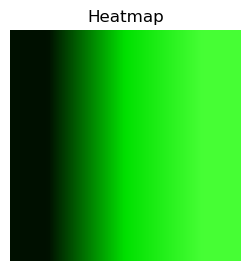

1/1 [==============================] - 0s 33ms/step


array([[6.9725546e-03, 2.3197581e-03, 1.0150519e-03, 3.4193991e-04,
        9.8932940e-01, 2.1395297e-05]], dtype=float32)

In [21]:
visualize_grad_cam_heatmap(model_kfold, "seg_test/seg_test/sea/20114.jpg", last_conv_layer_name)
model_kfold.predict(preprocess_image("seg_test/seg_test/sea/20114.jpg", size=(80,80)))

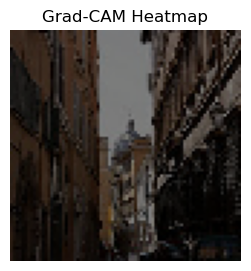

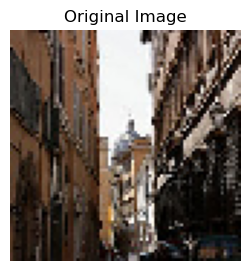

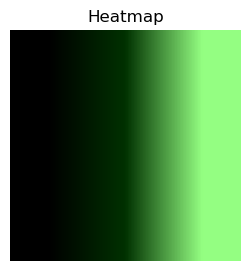

1/1 [==============================] - 0s 32ms/step


array([[1.3546046e-02, 3.1756449e-03, 5.8708219e-03, 7.2373322e-04,
        9.7665286e-01, 3.0843843e-05]], dtype=float32)

In [22]:
visualize_grad_cam_heatmap(model_kfold, "seg_test/seg_test/street/20070.jpg", last_conv_layer_name)
model_kfold.predict(preprocess_image("seg_test/seg_test/street/20070.jpg", size=(80,80)))

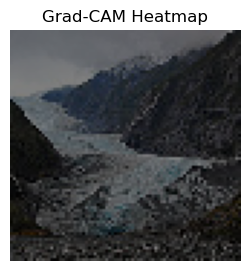

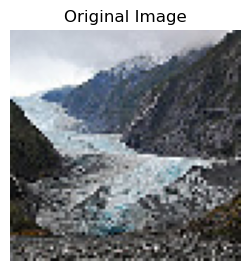

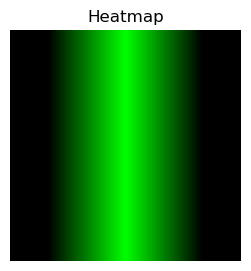

1/1 [==============================] - 0s 32ms/step


array([[1.5719056e-02, 2.9888330e-03, 3.3065134e-03, 8.8405359e-04,
        9.7707224e-01, 2.9266801e-05]], dtype=float32)

In [23]:
visualize_grad_cam_heatmap(model_kfold, "seg_test/seg_test/glacier/20111.jpg", last_conv_layer_name)
model_kfold.predict(preprocess_image("seg_test/seg_test/glacier/20111.jpg", size=(80,80)))

 # Conclusion

I conclude that CNN works quite well on this dataset, when compared to a normal neural network. The neural network model from the previous exercise had an accuracy of 0.45 and this model has an accuracy of around 70%. When visualising the confusion matrix, it is clear that the model is able to predict the images quite well. However, when picking 3 random images for each class label, the model is not able to predict the images correctly. This is probably due to the fact that the model is overfitting on the training set. The model tends to always predict that the image is a glacier. I think this has to do with the k-fold cross validation. The model is trained on the same images multiple times, which causes the model to overfit on the training set.

For Grad-CAM I noticed that my previously chosen pixel size (40x40) generates a much pixelated heatmap, when trying to visualise this with Grad-CAM the heatmap outputs a smooth color gradient. This was likely due to the fact that the pixel size is too small.
I retrained the model for a pixel size of 80x80 and the validation accuracy has drastically increased from 75% to 86%. The results from the Grad-CAM was the same since all the visualisation shows is huge color gradient. The reason for this might also be because the model always predicts the same category, which is seas. This is likely due to overfitting.